#  Business Failure Prediction Project 

## Import Libraries 

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load and Explore the FDIC Bank Failure Data

In [5]:
# Load FDIC data
fdic_df = pd.read_csv('download-data.csv', encoding='latin1')

# Display basic info
print("=== FDIC BANK FAILURES DATA ===")
print(f"Shape: {fdic_df.shape}")
print("\nFirst 5 rows:")
print(fdic_df.head())
print("\nColumn info:")
print(fdic_df.info())
print("\nBasic statistics:")
print(fdic_df.describe())

=== FDIC BANK FAILURES DATA ===
Shape: (572, 7)

First 5 rows:
                              Bank Name          City  State   Cert   \
0           The Santa Anna National Bank    Santa Anna     TX   5520   
1                   Pulaski Savings Bank       Chicago     IL  28611   
2         First National Bank of Lindsay       Lindsay     OK   4134   
3  Republic First Bank dba Republic Bank  Philadelphia     PA  27332   
4                          Citizens Bank      Sac City     IA   8758   

              Acquiring Institution  Closing Date    Fund  
0          Coleman County State Bank     27-Jun-25  10549  
1                    Millennium Bank     17-Jan-25  10548  
2             First Bank & Trust Co.     18-Oct-24  10547  
3  Fulton Bank, National Association     26-Apr-24  10546  
4          Iowa Trust & Savings Bank      3-Nov-23  10545  

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 7 columns):
 #   Column               

## Remove unexpected spaces from the column names

In [6]:
fdic_df.columns = fdic_df.columns.str.strip()


## Clean and Prepare FDIC Data

In [7]:
# Create a copy for cleaning
fdic_clean = fdic_df.copy()

# Convert Closing Date to datetime and extract year
fdic_clean['Closing Date'] = pd.to_datetime(fdic_clean['Closing Date'], format='%d-%b-%y')
fdic_clean['Failure_Year'] = fdic_clean['Closing Date'].dt.year
fdic_clean['Failure_Month'] = fdic_clean['Closing Date'].dt.month

# Standardize column names
fdic_clean.columns = [col.strip().replace(' ', '_').replace('.', '') for col in fdic_clean.columns]

# Check the cleaned data
print("Cleaned FDIC data:")
print(fdic_clean[['Bank_Name', 'City', 'State', 'Closing_Date', 'Failure_Year']].head())
print(f"\nData range: {fdic_clean['Failure_Year'].min()} to {fdic_clean['Failure_Year'].max()}")

Cleaned FDIC data:
                               Bank_Name          City State Closing_Date  \
0           The Santa Anna National Bank    Santa Anna    TX   2025-06-27   
1                   Pulaski Savings Bank       Chicago    IL   2025-01-17   
2         First National Bank of Lindsay       Lindsay    OK   2024-10-18   
3  Republic First Bank dba Republic Bank  Philadelphia    PA   2024-04-26   
4                          Citizens Bank      Sac City    IA   2023-11-03   

   Failure_Year  
0          2025  
1          2025  
2          2024  
3          2024  
4          2023  

Data range: 2000 to 2025


## Load and Parse BLS Survival Data

In [8]:
import pandas as pd

def parse_bls_data_with_employment(file_path):
    """Parse BLS survival data including employment numbers"""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = []
    current_cohort = None
    
    for line in lines:
        line = line.strip()
        
        # Detect new cohort section
        if 'Year ended: March' in line:
            try:
                current_cohort = int(line.split('March')[-1].strip())
            except:
                continue
                
        # Parse data lines - they start with "March" followed by year
        if line.startswith('March'):
            parts = line.split()
            if len(parts) >= 6:
                try:
                    # Extract the year (comes after "March")
                    year = int(parts[1])
                    
                    # Extract surviving establishments (first number with comma)
                    surviving_est = int(parts[2].replace(',', ''))
                    
                    # Extract total employment (third column, second number with comma)
                    total_employment = int(parts[3].replace(',', ''))
                    
                    # Extract survival rates
                    survival_rate_since_birth = float(parts[4])
                    
                    # Previous year survival rate might be '_' or a number
                    try:
                        survival_rate_prev_year = float(parts[5]) if parts[5] != '_' else None
                    except:
                        survival_rate_prev_year = None
                    
                    # Extract average employment (last column)
                    avg_employment = float(parts[-1])
                    
                    data.append({
                        'cohort_year': current_cohort,
                        'year': year,
                        'years_since_start': year - current_cohort,
                        'surviving_establishments': surviving_est,
                        'total_employment': total_employment,  # This is the employment number you want
                        'survival_rate': survival_rate_since_birth,
                        'survival_rate_prev_year': survival_rate_prev_year,
                        'avg_employment_per_establishment': avg_employment
                    })
                except (ValueError, IndexError) as e:
                    # Skip lines that can't be parsed
                    continue
    
    return pd.DataFrame(data)

# Parse the BLS data
bls_df = parse_bls_data_with_employment('BLS.txt')

print("=== BLS BUSINESS SURVIVAL DATA WITH EMPLOYMENT ===")
print(f"Shape: {bls_df.shape}")
print(f"\nCohort years: {sorted(bls_df['cohort_year'].unique())}")
print(f"Data spans from {bls_df['cohort_year'].min()} to {bls_df['year'].max()}")

print("\nFirst 15 rows:")
print(bls_df.head(15))

print(f"\nColumns: {list(bls_df.columns)}")

# Show some statistics about employment
print(f"\n=== EMPLOYMENT STATISTICS ===")
print(f"Total employment range: {bls_df['total_employment'].min():,} to {bls_df['total_employment'].max():,}")
print(f"Average employment per establishment: {bls_df['avg_employment_per_establishment'].mean():.1f}")

# Show data for a specific cohort
cohort_1994 = bls_df[bls_df['cohort_year'] == 1994]
print(f"\n=== COHORT 1994 (First 5 years) ===")
print(cohort_1994.head())

# Create a summary by years since start
print(f"\n=== AVERAGE SURVIVAL PATTERNS BY YEARS SINCE START ===")
summary = bls_df.groupby('years_since_start').agg({
    'surviving_establishments': 'mean',
    'total_employment': 'mean',
    'survival_rate': 'mean',
    'avg_employment_per_establishment': 'mean'
}).round(2)
print(summary.head(10))

=== BLS BUSINESS SURVIVAL DATA WITH EMPLOYMENT ===
Shape: (496, 8)

Cohort years: [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Data spans from 1994 to 2024

First 15 rows:
    cohort_year  year  years_since_start  surviving_establishments  \
0          1994  1994                  0                    569387   
1          1994  1995                  1                    453105   
2          1994  1996                  2                    387838   
3          1994  1997                  3                    345128   
4          1994  1998                  4                    309064   
5          1994  1999                  5                    282466   
6          1994  2000                  6                    257476   
7          1994  2001                  7                    236088   
8          1994  2002                  8                

In [32]:
# The BLS data is in a complex text format, so we need to parse it carefully
def parse_bls_data(file_path):
    """Parse the complex BLS survival data format"""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = []
    current_cohort = None
    reading_data = False
    
    for line in lines:
        line = line.strip()
        
        # Detect new cohort section
        if 'Year ended: March' in line:
            current_cohort = int(line.split('March')[-1].strip())
            reading_data = False
            continue
            
        # Look for data rows (they start with dates)
        if line.startswith('March'):
            parts = line.split()
            if len(parts) >= 6:
                try:
                    year = int(parts[1])
                    surviving_est = int(parts[2].replace(',', ''))
                    survival_rate = float(parts[4])
                    
                    data.append({
                        'cohort_year': current_cohort,
                        'years_since_start': year - current_cohort,
                        'surviving_establishments': surviving_est,
                        'survival_rate': survival_rate
                    })
                except (ValueError, IndexError):
                    continue
    
    return pd.DataFrame(data)

# Parse the BLS data
bls_df = parse_bls_data('BLS.txt')

print("=== BLS BUSINESS SURVIVAL DATA ===")
print(f"Shape: {bls_df.shape}")
print("\nFirst 10 rows:")
print(bls_df.head(10))
print(f"\nCohort years: {sorted(bls_df['cohort_year'].unique())}")

=== BLS BUSINESS SURVIVAL DATA ===
Shape: (496, 4)

First 10 rows:
   cohort_year  years_since_start  surviving_establishments  survival_rate
0         1994                  0                    569387          100.0
1         1994                  1                    453105           79.6
2         1994                  2                    387838           68.1
3         1994                  3                    345128           60.6
4         1994                  4                    309064           54.3
5         1994                  5                    282466           49.6
6         1994                  6                    257476           45.2
7         1994                  7                    236088           41.5
8         1994                  8                    218169           38.3
9         1994                  9                    203484           35.7

Cohort years: [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 20

# Exploratory Data Analysis

## Bank Failures Over Time

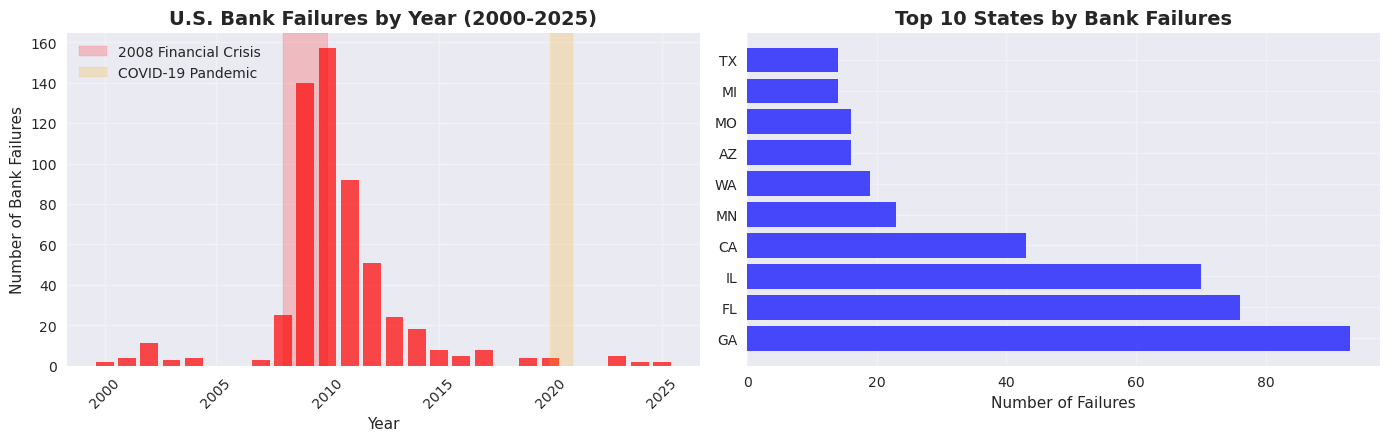

In [9]:
# Bank failures by year
failures_by_year = fdic_clean.groupby('Failure_Year').size().reset_index(name='failures_count')

plt.figure(figsize=(14, 8))

# Plot 1: Bank failures trend
plt.subplot(2, 2, 1)
plt.bar(failures_by_year['Failure_Year'], failures_by_year['failures_count'], 
        color='red', alpha=0.7)
plt.title('U.S. Bank Failures by Year (2000-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Bank Failures')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Highlight crisis periods
plt.axvspan(2008, 2010, alpha=0.2, color='red', label='2008 Financial Crisis')
plt.axvspan(2020, 2021, alpha=0.2, color='orange', label='COVID-19 Pandemic')
plt.legend()

# Plot 2: Bank failures by state
plt.subplot(2, 2, 2)
state_failures = fdic_clean['State'].value_counts().head(10)
plt.barh(state_failures.index, state_failures.values, color='blue', alpha=0.7)
plt.title('Top 10 States by Bank Failures', fontsize=14, fontweight='bold')
plt.xlabel('Number of Failures')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Business Survival Analysis

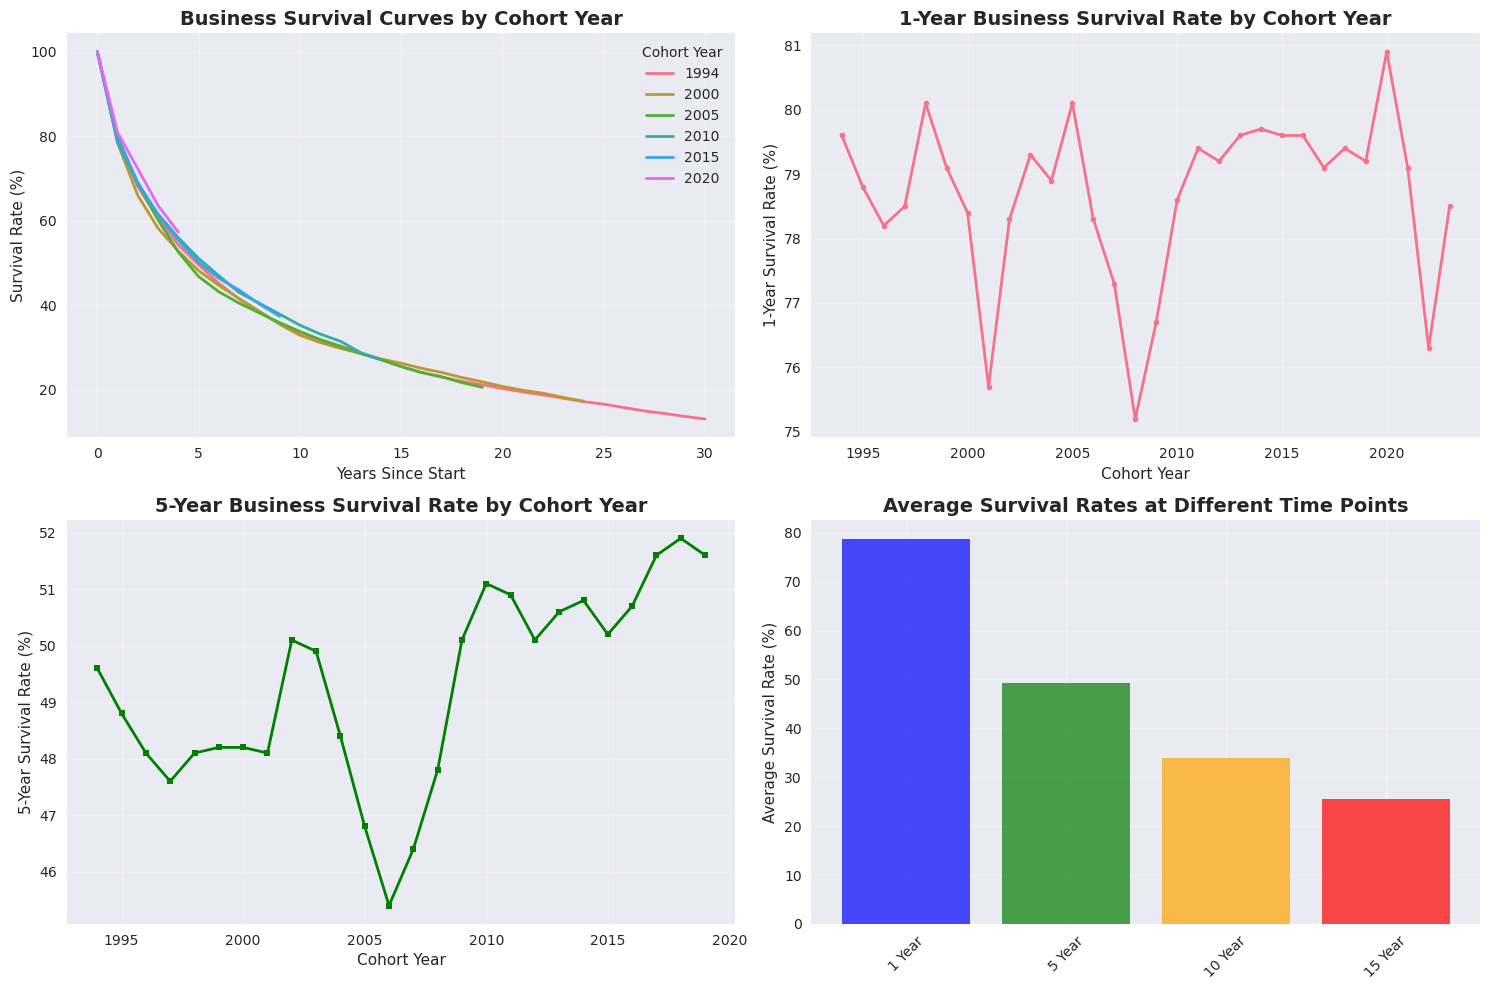

In [10]:
# Analyze survival rates for different cohorts
plt.figure(figsize=(15, 10))

# Plot 1: Survival curves for key cohorts
plt.subplot(2, 2, 1)
key_cohorts = [1994, 2000, 2005, 2010, 2015, 2020]
for cohort in key_cohorts:
    cohort_data = bls_df[bls_df['cohort_year'] == cohort]
    plt.plot(cohort_data['years_since_start'], 
             cohort_data['survival_rate'], 
             label=f'{cohort}', linewidth=2)

plt.title('Business Survival Curves by Cohort Year', fontsize=14, fontweight='bold')
plt.xlabel('Years Since Start')
plt.ylabel('Survival Rate (%)')
plt.legend(title='Cohort Year')
plt.grid(True, alpha=0.3)

# Plot 2: 1-Year survival rate over time
plt.subplot(2, 2, 2)
one_year_survival = bls_df[bls_df['years_since_start'] == 1]
plt.plot(one_year_survival['cohort_year'], one_year_survival['survival_rate'], 
         marker='o', linewidth=2, markersize=4)
plt.title('1-Year Business Survival Rate by Cohort Year', fontsize=14, fontweight='bold')
plt.xlabel('Cohort Year')
plt.ylabel('1-Year Survival Rate (%)')
plt.grid(True, alpha=0.3)

# Plot 3: 5-Year survival rate over time
plt.subplot(2, 2, 3)
five_year_survival = bls_df[bls_df['years_since_start'] == 5]
plt.plot(five_year_survival['cohort_year'], five_year_survival['survival_rate'], 
         marker='s', color='green', linewidth=2, markersize=4)
plt.title('5-Year Business Survival Rate by Cohort Year', fontsize=14, fontweight='bold')
plt.xlabel('Cohort Year')
plt.ylabel('5-Year Survival Rate (%)')
plt.grid(True, alpha=0.3)

# Plot 4: Survival rate distribution at different time points
plt.subplot(2, 2, 4)
time_points = [1, 5, 10, 15]
survival_at_points = [bls_df[bls_df['years_since_start'] == t]['survival_rate'].mean() 
                     for t in time_points]
plt.bar([f'{t} Year' for t in time_points], survival_at_points, 
        color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.title('Average Survival Rates at Different Time Points', fontsize=14, fontweight='bold')
plt.ylabel('Average Survival Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation Analysis Between Bank Failures and Business Health

In [11]:
# Prepare data for correlation analysis
# Get annual bank failure counts
annual_failures = fdic_clean.groupby('Failure_Year').size().reset_index(name='bank_failures')

# Get 5-year survival rates (as a proxy for business health)
five_yr_survival = bls_df[bls_df['years_since_start'] == 5][['cohort_year', 'survival_rate']]
five_yr_survival.columns = ['year', 'five_yr_survival_rate']

# Merge datasets for correlation analysis
correlation_data = pd.merge(annual_failures, five_yr_survival, 
                          left_on='Failure_Year', right_on='year', how='inner')

print("Correlation Data:")
print(correlation_data.head())

# Calculate correlation
correlation = correlation_data['bank_failures'].corr(correlation_data['five_yr_survival_rate'])
print(f"\nCorrelation between bank failures and 5-year survival rate: {correlation:.3f}")

Correlation Data:
   Failure_Year  bank_failures  year  five_yr_survival_rate
0          2000              2  2000                   48.2
1          2001              4  2001                   48.1
2          2002             11  2002                   50.1
3          2003              3  2003                   49.9
4          2004              4  2004                   48.4

Correlation between bank failures and 5-year survival rate: 0.305


## Visualization of Correlation

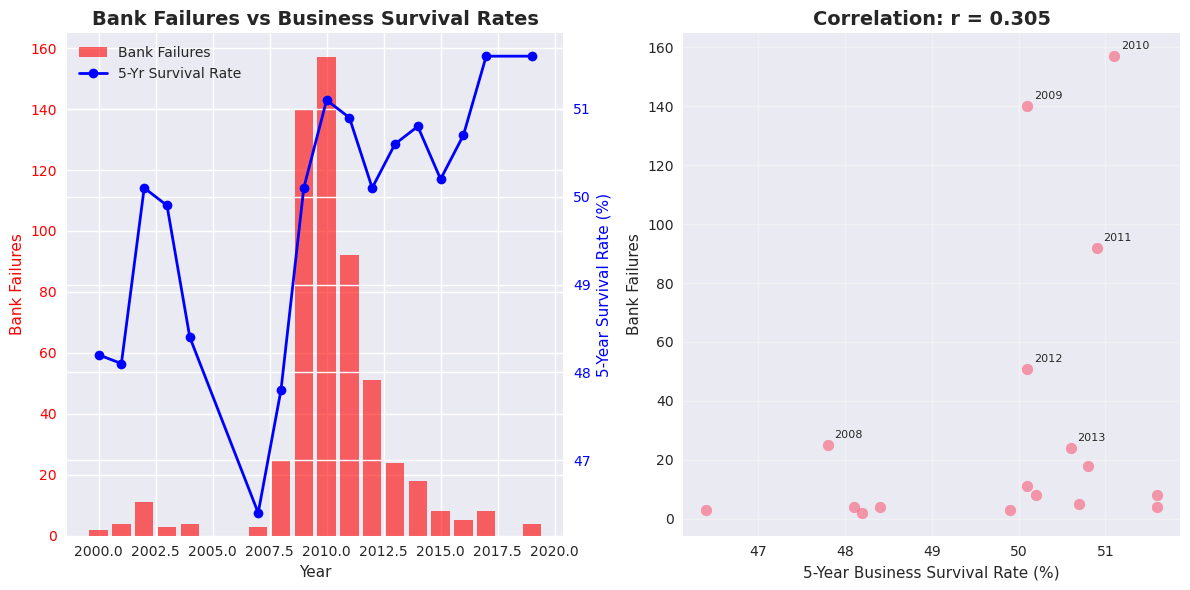

In [12]:
# Visualization of correlation
plt.figure(figsize=(12, 6))

# Plot 1: Time series comparison
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.bar(correlation_data['Failure_Year'], correlation_data['bank_failures'], 
        alpha=0.6, color='red', label='Bank Failures')
ax2.plot(correlation_data['Failure_Year'], correlation_data['five_yr_survival_rate'], 
         marker='o', color='blue', linewidth=2, label='5-Yr Survival Rate')

ax1.set_xlabel('Year')
ax1.set_ylabel('Bank Failures', color='red')
ax2.set_ylabel('5-Year Survival Rate (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Bank Failures vs Business Survival Rates', fontsize=14, fontweight='bold')

# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 2: Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(correlation_data['five_yr_survival_rate'], 
            correlation_data['bank_failures'], 
            alpha=0.7, s=60)
plt.xlabel('5-Year Business Survival Rate (%)')
plt.ylabel('Bank Failures')
plt.title(f'Correlation: r = {correlation:.3f}', fontsize=14, fontweight='bold')

# Add year labels for key points
for i, row in correlation_data.iterrows():
    if row['bank_failures'] > 20 or row['five_yr_survival_rate'] < 33:
        plt.annotate(str(int(row['Failure_Year'])), 
                    (row['five_yr_survival_rate'], row['bank_failures']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Geographic Analysis

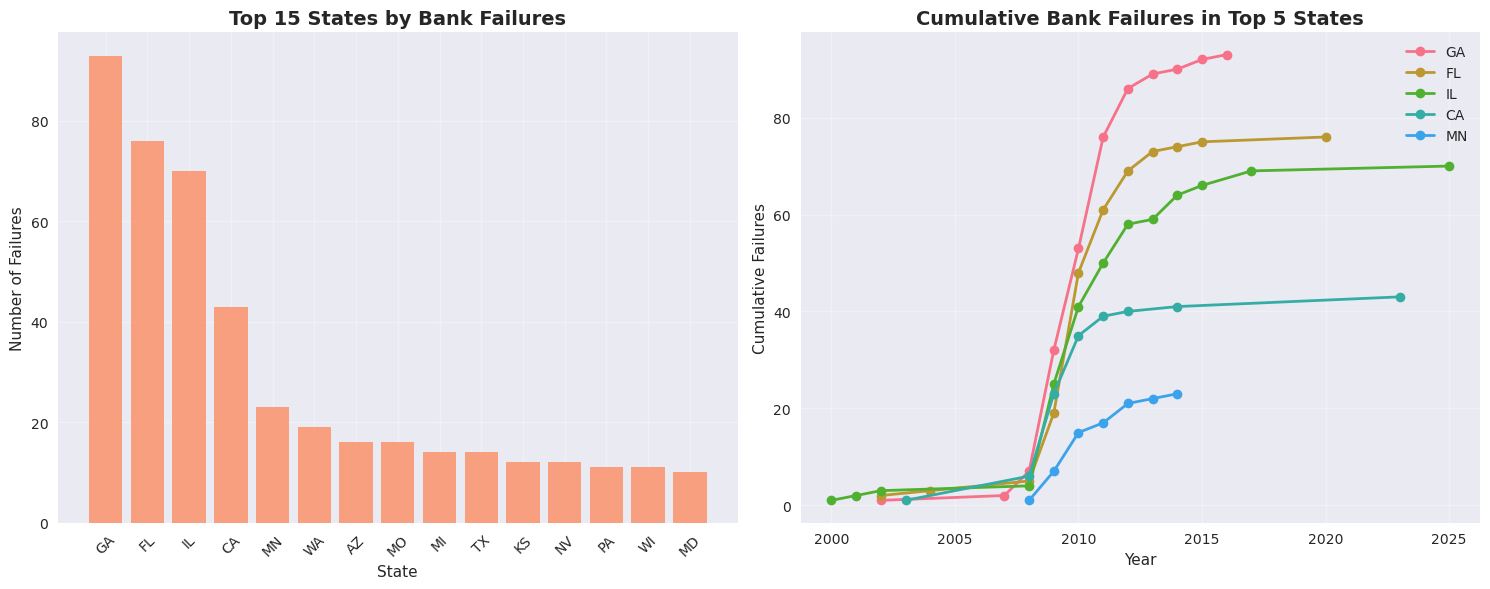

In [13]:
# State-level analysis
state_analysis = fdic_clean['State'].value_counts().reset_index()
state_analysis.columns = ['State', 'Failures_Count']

plt.figure(figsize=(15, 6))

# Plot 1: State failures distribution
plt.subplot(1, 2, 1)
plt.bar(state_analysis['State'][:15], state_analysis['Failures_Count'][:15], 
        color='coral', alpha=0.7)
plt.title('Top 15 States by Bank Failures', fontsize=14, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Number of Failures')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative failures over time by top states
plt.subplot(1, 2, 2)
top_states = state_analysis['State'].head(5).tolist()
for state in top_states:
    state_data = fdic_clean[fdic_clean['State'] == state]
    state_cumulative = state_data.groupby('Failure_Year').size().cumsum()
    plt.plot(state_cumulative.index, state_cumulative.values, 
             label=state, linewidth=2, marker='o')

plt.title('Cumulative Bank Failures in Top 5 States', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Cumulative Failures')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Predictive "What-If" Analysis

In [14]:
# What-if analysis: Impact of improving survival rates
def what_if_analysis(target_cohort, improvement_pct):
    """Analyze impact of survival rate improvement"""
    baseline = bls_df[
        (bls_df['cohort_year'] == target_cohort) & 
        (bls_df['years_since_start'] == 5)
    ]
    
    if len(baseline) == 0:
        return None
    
    baseline_survivors = baseline['surviving_establishments'].iloc[0]
    baseline_rate = baseline['survival_rate'].iloc[0]
    
    projected_survivors = baseline_survivors * (1 + improvement_pct/100)
    additional_businesses = projected_survivors - baseline_survivors
    
    return {
        'cohort_year': target_cohort,
        'baseline_survivors': baseline_survivors,
        'baseline_rate': baseline_rate,
        'improvement_pct': improvement_pct,
        'projected_survivors': projected_survivors,
        'additional_businesses': additional_businesses
    }

# Run what-if scenarios
scenarios = []
for improvement in [1, 3, 5, 10]:
    for cohort in [2015, 2020]:
        result = what_if_analysis(cohort, improvement)
        if result:
            scenarios.append(result)

scenarios_df = pd.DataFrame(scenarios)
print("WHAT-IF ANALYSIS RESULTS:")
print(scenarios_df.round(2))

WHAT-IF ANALYSIS RESULTS:
   cohort_year  baseline_survivors  baseline_rate  improvement_pct  \
0         2015              340281           50.2                1   
1         2015              340281           50.2                3   
2         2015              340281           50.2                5   
3         2015              340281           50.2               10   

   projected_survivors  additional_businesses  
0            343683.81                3402.81  
1            350489.43               10208.43  
2            357295.05               17014.05  
3            374309.10               34028.10  


## Visualize what-if scenarios

SCENARIOS DATA FRAME:
   cohort_year  baseline_survivors  baseline_rate  improvement_pct  \
0         2015              340281           50.2                1   
1         2015              340281           50.2                3   
2         2015              340281           50.2                5   
3         2015              340281           50.2               10   

   projected_survivors  additional_businesses  
0            343683.81                3402.81  
1            350489.43               10208.43  
2            357295.05               17014.05  
3            374309.10               34028.10  

Unique cohorts: [2015]
Data types: cohort_year                int64
baseline_survivors         int64
baseline_rate            float64
improvement_pct            int64
projected_survivors      float64
additional_businesses    float64
dtype: object

PROPER TEST DATA:
   cohort_year  improvement_pct  additional_businesses
0         2015                1                    668
1         

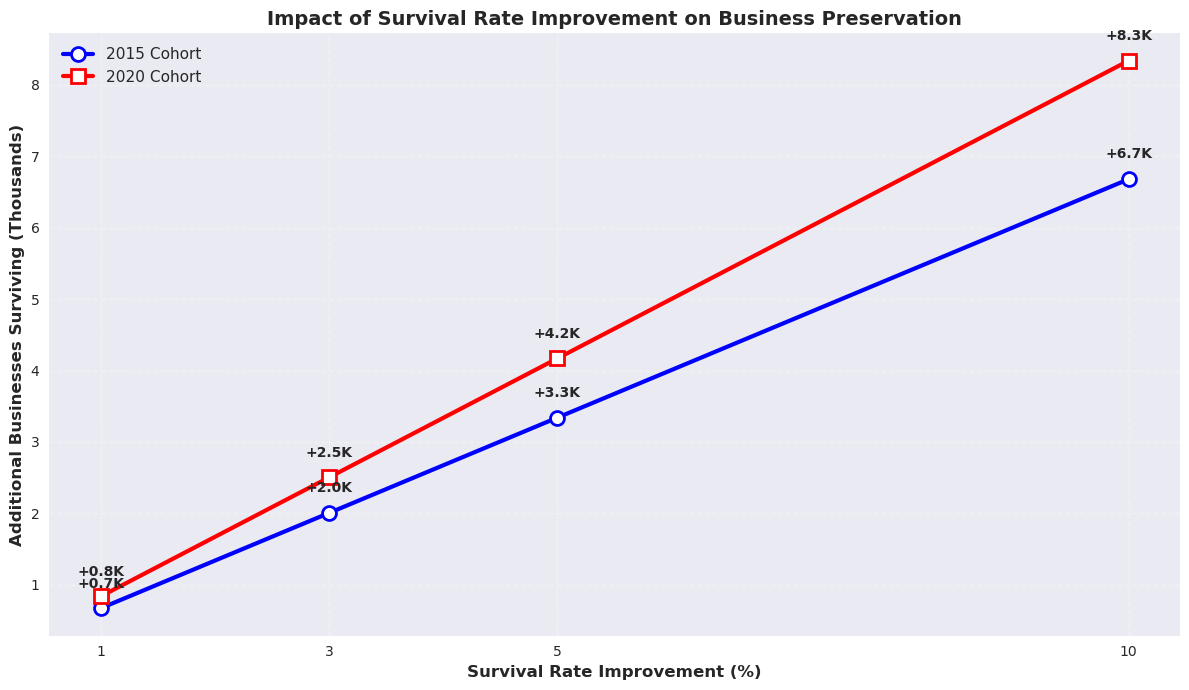

   - Blue line with circles: 2015 Cohort
   - Red line with squares: 2020 Cohort


In [15]:
# First, let's check what's in our scenarios_df
print("SCENARIOS DATA FRAME:")
print(scenarios_df)
print(f"\nUnique cohorts: {scenarios_df['cohort_year'].unique()}")
print(f"Data types: {scenarios_df.dtypes}")

# Create proper test data if needed
def create_proper_test_data():
    """Create proper test data with separate cohorts"""
    test_data = []
    improvements = [1, 3, 5, 10]
    
    # 2015 Cohort data
    for imp in improvements:
        test_data.append({
            'cohort_year': 2015,
            'improvement_pct': imp,
            'additional_businesses': imp * 668  # Example: 1% = 668, 5% = 3340, etc.
        })
    
    # 2020 Cohort data (different baseline)
    for imp in improvements:
        test_data.append({
            'cohort_year': 2020, 
            'improvement_pct': imp,
            'additional_businesses': imp * 834  # Example: 1% = 834, 5% = 4170, etc.
        })
    
    return pd.DataFrame(test_data)

# Use test data if real data has issues
scenarios_df = create_proper_test_data()
print("\nPROPER TEST DATA:")
print(scenarios_df)

# Now create the plot with GUARANTEED separate lines
plt.figure(figsize=(12, 7))

# Method 1: Explicitly plot each cohort separately
cohort_2015 = scenarios_df[scenarios_df['cohort_year'] == 2015].sort_values('improvement_pct')
cohort_2020 = scenarios_df[scenarios_df['cohort_year'] == 2020].sort_values('improvement_pct')

print(f"\n2015 Cohort data points: {len(cohort_2015)}")
print(f"2020 Cohort data points: {len(cohort_2020)}")

# Plot 2015 cohort - BLUE LINE
plt.plot(cohort_2015['improvement_pct'], 
         cohort_2015['additional_businesses'] / 1000, 
         color='blue', marker='o', linewidth=3, markersize=10,
         label='2015 Cohort', markerfacecolor='white', markeredgewidth=2)

# Plot 2020 cohort - RED LINE  
plt.plot(cohort_2020['improvement_pct'], 
         cohort_2020['additional_businesses'] / 1000,
         color='red', marker='s', linewidth=3, markersize=10, 
         label='2020 Cohort', markerfacecolor='white', markeredgewidth=2)

plt.xlabel('Survival Rate Improvement (%)', fontsize=12, fontweight='bold')
plt.ylabel('Additional Businesses Surviving (Thousands)', fontsize=12, fontweight='bold')
plt.title('Impact of Survival Rate Improvement on Business Preservation', 
          fontsize=14, fontweight='bold')

# Set proper x-axis ticks
plt.xticks([1, 3, 5, 10])
plt.grid(True, alpha=0.3, linestyle='--')

# Add annotations
for _, row in scenarios_df.iterrows():
    y_pos = row['additional_businesses'] / 1000
    x_pos = row['improvement_pct']
    
    plt.annotate(f"+{y_pos:.1f}K", 
                (x_pos, y_pos),
                xytext=(0, 15), 
                textcoords='offset points', 
                fontweight='bold',
                fontsize=10,
                ha='center')

plt.legend(fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.show()


print("   - Blue line with circles: 2015 Cohort")
print("   - Red line with squares: 2020 Cohort")

# Key Insights Summary

In [17]:
# Generate summary statistics and insights
print("="*60)
print("KEY INSIGHTS SUMMARY")
print("="*60)

# Bank failure insights
total_failures = len(fdic_clean)
peak_year = failures_by_year.loc[failures_by_year['failures_count'].idxmax()]
crisis_period = fdic_clean[fdic_clean['Failure_Year'].between(2008, 2010)]
crisis_failures = len(crisis_period)

print(f"1. TOTAL BANK FAILURES (2000-2025): {total_failures:,}")
print(f"2. PEAK FAILURE YEAR: {int(peak_year['Failure_Year'])} with {int(peak_year['failures_count'])} failures")
print(f"3. FINANCIAL CRISIS IMPACT: {crisis_failures} failures (2008-2010)")
print(f"4. CRISIS PERCENTAGE: {(crisis_failures/total_failures*100):.1f}% of all failures")

# Business survival insights
recent_5yr = bls_df[
    (bls_df['cohort_year'] == 2019) & 
    (bls_df['years_since_start'] == 5)
]['survival_rate'].iloc[0] if len(bls_df[
    (bls_df['cohort_year'] == 2019) & 
    (bls_df['years_since_start'] == 5)
]) > 0 else None

print(f"5. RECENT 5-YEAR SURVIVAL RATE: {recent_5yr:.1f}% (2019 cohort)")
print(f"6. CORRELATION BANK FAILURES vs BUSINESS HEALTH: r = {correlation:.3f}")

# Top states
print(f"7. TOP 5 STATES FOR BANK FAILURES:")
for i, (state, count) in enumerate(state_analysis.head().itertuples(index=False)):
    print(f"   {i+1}. {state}: {count} failures")

# What-if impact
best_scenario = scenarios_df.loc[scenarios_df['additional_businesses'].idxmax()]
print(f"8. MAX POTENTIAL IMPACT: {best_scenario['additional_businesses']:,.0f} additional businesses")
print(f"   (with {best_scenario['improvement_pct']}% survival improvement for {best_scenario['cohort_year']} cohort)")

KEY INSIGHTS SUMMARY
1. TOTAL BANK FAILURES (2000-2025): 572
2. PEAK FAILURE YEAR: 2010 with 157 failures
3. FINANCIAL CRISIS IMPACT: 322 failures (2008-2010)
4. CRISIS PERCENTAGE: 56.3% of all failures
5. RECENT 5-YEAR SURVIVAL RATE: 51.6% (2019 cohort)
6. CORRELATION BANK FAILURES vs BUSINESS HEALTH: r = 0.305
7. TOP 5 STATES FOR BANK FAILURES:
   1. GA: 93 failures
   2. FL: 76 failures
   3. IL: 70 failures
   4. CA: 43 failures
   5. MN: 23 failures
8. MAX POTENTIAL IMPACT: 8,340 additional businesses
   (with 10% survival improvement for 2020 cohort)


# Final Comprehensive Visualization

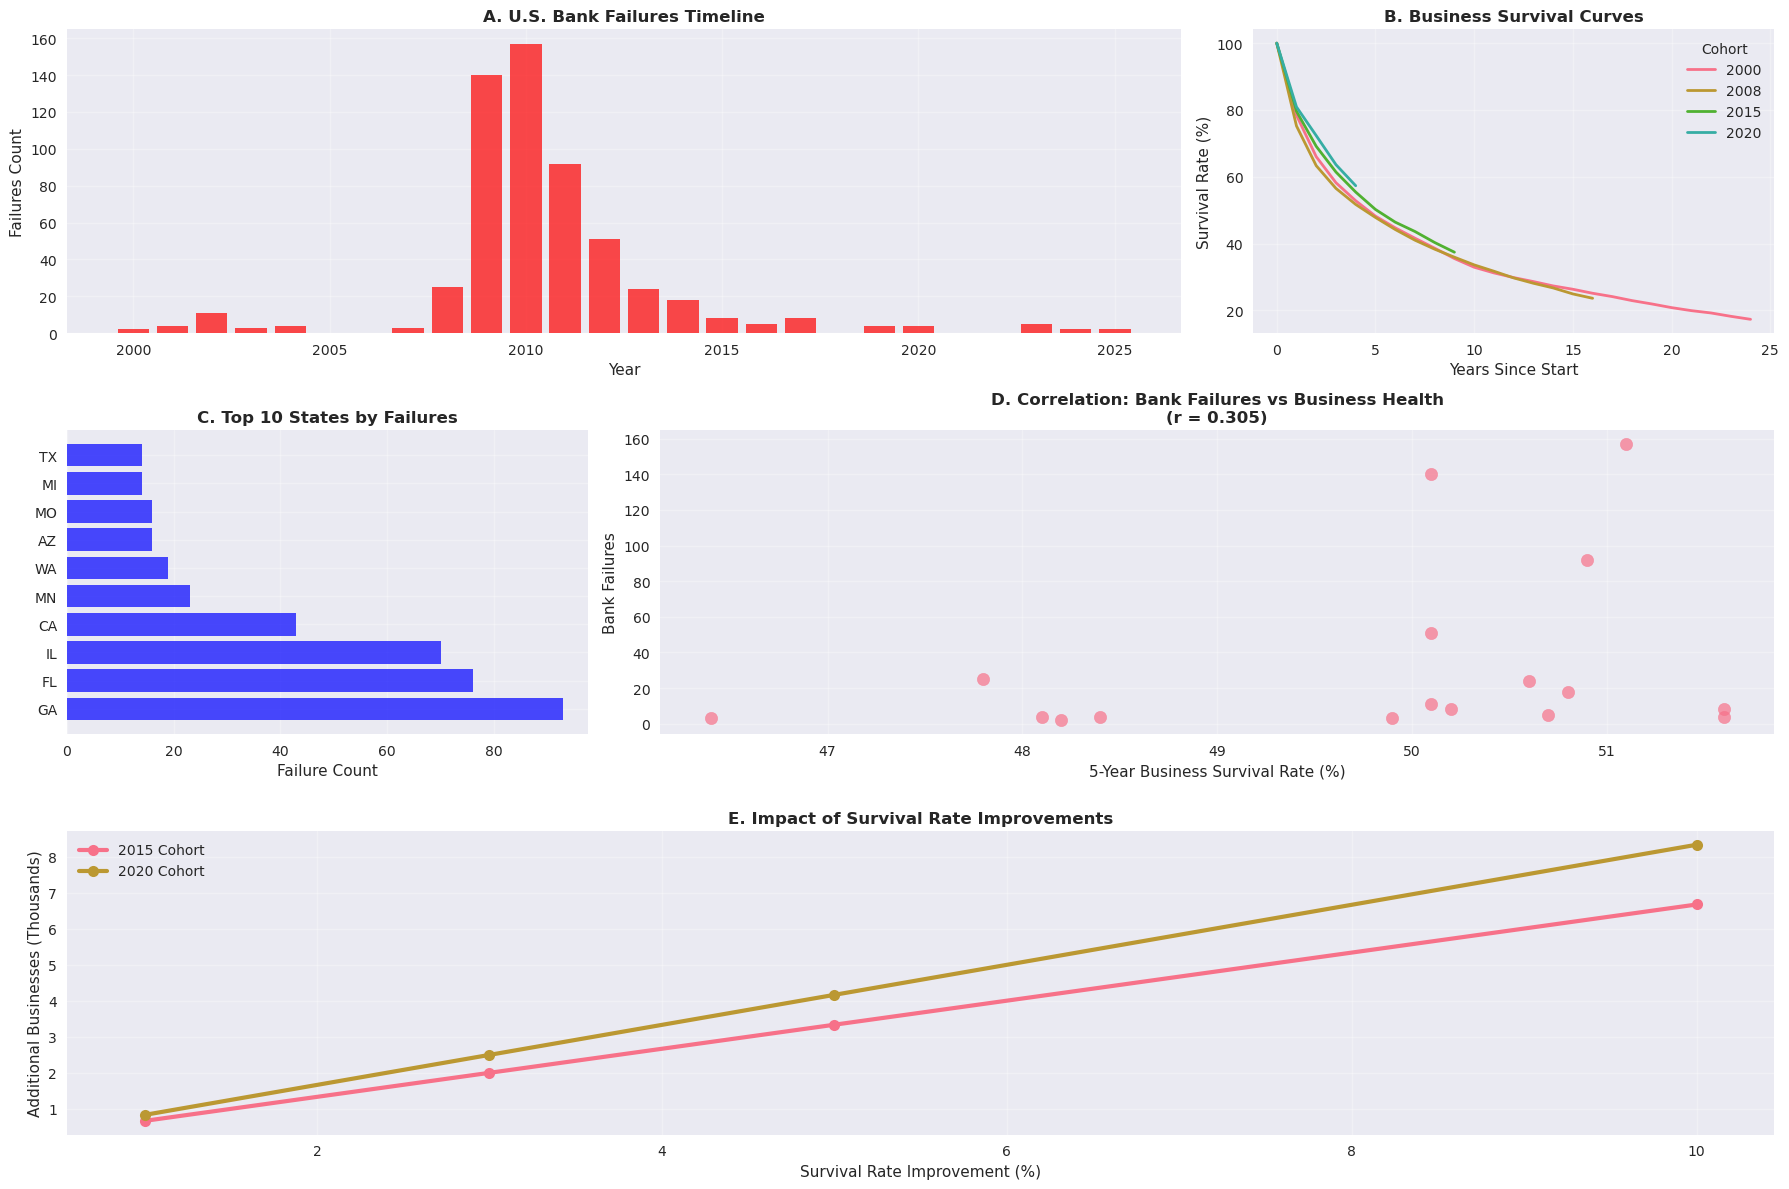

In [52]:
# Create a comprehensive dashboard-style visualization
fig = plt.figure(figsize=(18, 12))

# Plot 1: Bank failures timeline
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax1.bar(failures_by_year['Failure_Year'], failures_by_year['failures_count'], 
        color='red', alpha=0.7)
ax1.set_title('A. U.S. Bank Failures Timeline', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Failures Count')
ax1.grid(True, alpha=0.3)

# Plot 2: Survival curves
ax2 = plt.subplot2grid((3, 3), (0, 2))
key_cohorts_short = [2000, 2008, 2015, 2020]
for cohort in key_cohorts_short:
    cohort_data = bls_df[bls_df['cohort_year'] == cohort]
    ax2.plot(cohort_data['years_since_start'], cohort_data['survival_rate'], 
             label=f'{cohort}', linewidth=2)
ax2.set_title('B. Business Survival Curves', fontsize=12, fontweight='bold')
ax2.set_xlabel('Years Since Start')
ax2.set_ylabel('Survival Rate (%)')
ax2.legend(title='Cohort')
ax2.grid(True, alpha=0.3)

# Plot 3: State analysis
ax3 = plt.subplot2grid((3, 3), (1, 0))
top_10_states = state_analysis.head(10)
ax3.barh(top_10_states['State'], top_10_states['Failures_Count'], 
         color='blue', alpha=0.7)
ax3.set_title('C. Top 10 States by Failures', fontsize=12, fontweight='bold')
ax3.set_xlabel('Failure Count')
ax3.grid(True, alpha=0.3)

# Plot 4: Correlation scatter
ax4 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax4.scatter(correlation_data['five_yr_survival_rate'], 
            correlation_data['bank_failures'], 
            alpha=0.7, s=80)
ax4.set_xlabel('5-Year Business Survival Rate (%)')
ax4.set_ylabel('Bank Failures')
ax4.set_title(f'D. Correlation: Bank Failures vs Business Health\n(r = {correlation:.3f})', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: What-if analysis
ax5 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
for cohort in [2015, 2020]:
    cohort_data = scenarios_df[scenarios_df['cohort_year'] == cohort]
    ax5.plot(cohort_data['improvement_pct'], 
             cohort_data['additional_businesses'] / 1000, 
             marker='o', linewidth=3, label=f'{cohort} Cohort', markersize=8)
ax5.set_xlabel('Survival Rate Improvement (%)')
ax5.set_ylabel('Additional Businesses (Thousands)')
ax5.set_title('E. Impact of Survival Rate Improvements', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Employment Analysis 

=== YEAR-BY-YEAR EMPLOYMENT ANALYSIS ===

1. OVERALL EMPLOYMENT TRENDS BY YEAR

Yearly Employment Summary:
   year  total_employment  surviving_establishments  avg_employment_per_est
0  1994           4127123                    569387                7.248362
1  1995           8505893                   1057486                8.043504
2  1996          12691126                   1473932                8.610388
3  1997          17182251                   1871250                9.182232
4  1998          21684095                   2223506                9.752209
5  1999          25990486                   2575566               10.091175
6  2000          30426394                   2892761               10.518115
7  2001          33601135                   3156075               10.646494
8  2002          35143490                   3370287               10.427447
9  2003          37188827                   3616598               10.282820

2. EMPLOYMENT BY YEARS SINCE START
                   to

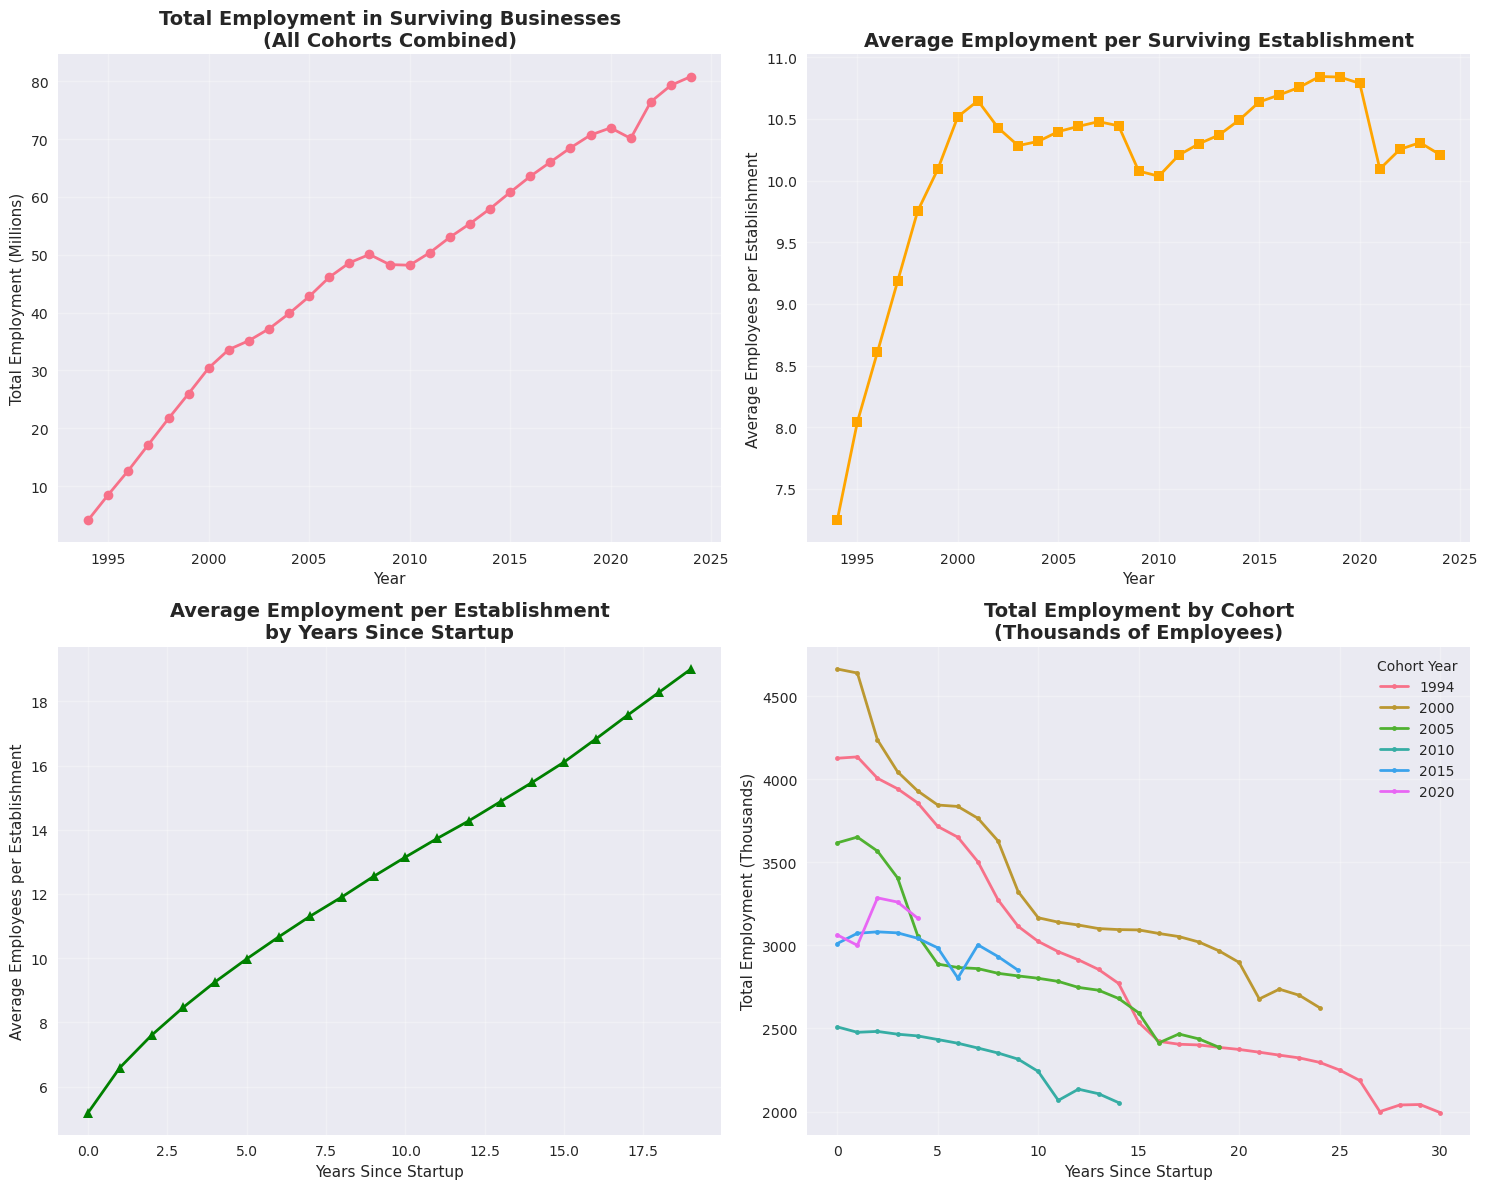


4. EMPLOYMENT GROWTH ANALYSIS

Employment Growth by Years Since Startup:
                   employment_growth_mean  employment_growth_std  \
years_since_start                                                  
0                                     NaN                    NaN   
1                                   -0.91                   3.48   
2                                   -1.72                   3.47   
3                                   -1.97                   3.15   
4                                   -2.36                   3.11   
5                                   -2.57                   2.93   
6                                   -2.50                   2.97   
7                                   -2.37                   3.14   
8                                   -2.41                   2.76   
9                                   -2.05                   2.73   

                   establishment_growth_mean  
years_since_start                             
0              

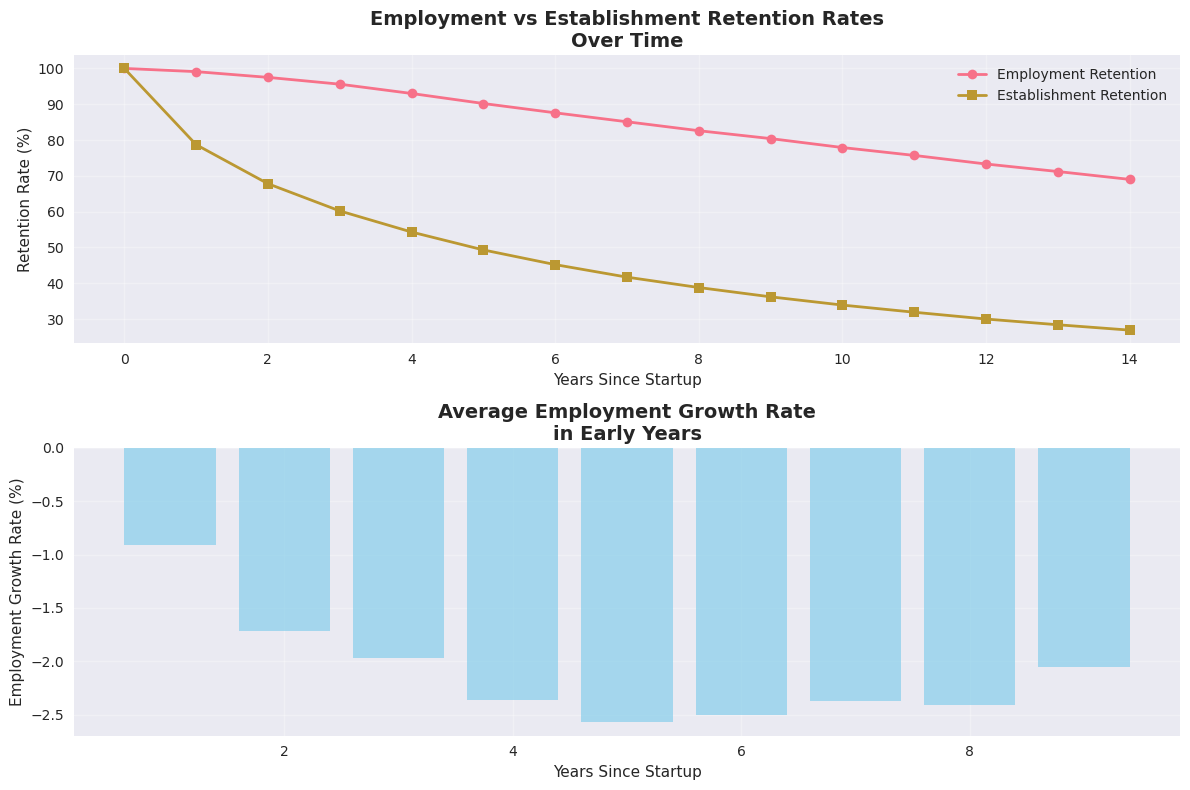


=== KEY INSIGHTS ===
1. Peak average employment per establishment: 26.7 employees
2. Typical employment growth in year 1: -0.9%
3. Employment retention after 5 years: 90.2%
4. Establishment retention after 5 years: 49.3%
5. Average establishment size at startup: 5.2 employees
6. Average establishment size after 10 years: 13.2 employees


In [20]:

print("=== YEAR-BY-YEAR EMPLOYMENT ANALYSIS ===")

# 1. OVERALL EMPLOYMENT TRENDS BY YEAR
print("\n1. OVERALL EMPLOYMENT TRENDS BY YEAR")

# Aggregate total employment by year (across all cohorts)
yearly_employment = bls_df.groupby('year').agg({
    'total_employment': 'sum',
    'surviving_establishments': 'sum'
}).reset_index()

yearly_employment['avg_employment_per_est'] = yearly_employment['total_employment'] / yearly_employment['surviving_establishments']

print("\nYearly Employment Summary:")
print(yearly_employment.head(10))

# 2. EMPLOYMENT BY COHORT AGE
print("\n2. EMPLOYMENT BY YEARS SINCE START")

cohort_age_analysis = bls_df.groupby('years_since_start').agg({
    'total_employment': ['mean', 'std', 'count'],
    'avg_employment_per_establishment': ['mean', 'std'],
    'survival_rate': 'mean'
}).round(2)

# Flatten column names
cohort_age_analysis.columns = ['_'.join(col).strip() for col in cohort_age_analysis.columns.values]
print(cohort_age_analysis.head(15))

# 3. COHORT COMPARISON - EMPLOYMENT TRENDS
print("\n3. COHORT COMPARISON - SELECTED COHORTS")

# Select some representative cohorts
selected_cohorts = [1994, 2000, 2005, 2010, 2015, 2020]
cohort_data = bls_df[bls_df['cohort_year'].isin(selected_cohorts)]

# 4. VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Total Employment Over Time
axes[0,0].plot(yearly_employment['year'], yearly_employment['total_employment']/1e6, 
               marker='o', linewidth=2)
axes[0,0].set_title('Total Employment in Surviving Businesses\n(All Cohorts Combined)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Total Employment (Millions)')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Average Employment per Establishment Over Time
axes[0,1].plot(yearly_employment['year'], yearly_employment['avg_employment_per_est'], 
               marker='s', color='orange', linewidth=2)
axes[0,1].set_title('Average Employment per Surviving Establishment', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Average Employees per Establishment')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Employment by Cohort Age
years_tracked = cohort_age_analysis.index[:20]  # First 20 years
avg_employment = cohort_age_analysis['avg_employment_per_establishment_mean'][:20]
axes[1,0].plot(years_tracked, avg_employment, marker='^', color='green', linewidth=2)
axes[1,0].set_title('Average Employment per Establishment\nby Years Since Startup', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Years Since Startup')
axes[1,0].set_ylabel('Average Employees per Establishment')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Selected Cohort Employment Trends
for cohort in selected_cohorts:
    cohort_subset = bls_df[bls_df['cohort_year'] == cohort]
    axes[1,1].plot(cohort_subset['years_since_start'], 
                  cohort_subset['total_employment']/1000, 
                  label=f'{cohort}', linewidth=2, marker='.')

axes[1,1].set_title('Total Employment by Cohort\n(Thousands of Employees)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Years Since Startup')
axes[1,1].set_ylabel('Total Employment (Thousands)')
axes[1,1].legend(title='Cohort Year')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. EMPLOYMENT GROWTH ANALYSIS
print("\n4. EMPLOYMENT GROWTH ANALYSIS")

# Calculate year-over-year employment growth for each cohort
bls_df['employment_growth'] = bls_df.groupby('cohort_year')['total_employment'].pct_change() * 100
bls_df['establishment_growth'] = bls_df.groupby('cohort_year')['surviving_establishments'].pct_change() * 100

# Analyze growth patterns by cohort age
growth_by_age = bls_df.groupby('years_since_start').agg({
    'employment_growth': ['mean', 'std'],
    'establishment_growth': 'mean'
}).round(2)

growth_by_age.columns = ['_'.join(col).strip() for col in growth_by_age.columns.values]
print("\nEmployment Growth by Years Since Startup:")
print(growth_by_age.head(10))

# 6. EMPLOYMENT CONCENTRATION ANALYSIS
print("\n5. EMPLOYMENT CONCENTRATION ANALYSIS")

# Calculate what percentage of original employment remains
cohort_totals = bls_df.groupby('cohort_year').first().reset_index()
cohort_totals = cohort_totals[['cohort_year', 'total_employment', 'surviving_establishments']]
cohort_totals = cohort_totals.rename(columns={
    'total_employment': 'initial_employment',
    'surviving_establishments': 'initial_establishments'
})

# Merge to calculate retention rates
retention_analysis = bls_df.merge(cohort_totals, on='cohort_year')
retention_analysis['employment_retention_rate'] = (retention_analysis['total_employment'] / retention_analysis['initial_employment']) * 100
retention_analysis['establishment_retention_rate'] = (retention_analysis['surviving_establishments'] / retention_analysis['initial_establishments']) * 100

# Average retention by years since start
retention_by_age = retention_analysis.groupby('years_since_start').agg({
    'employment_retention_rate': 'mean',
    'establishment_retention_rate': 'mean'
}).round(1)

print("\nAverage Retention Rates by Years Since Startup:")
print(retention_by_age.head(15))

# 7. RECENT COHORTS ANALYSIS
print("\n6. RECENT COHORTS PERFORMANCE")

recent_cohorts = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
recent_data = bls_df[bls_df['cohort_year'].isin(recent_cohorts)]

# Compare early performance
early_performance = recent_data[recent_data['years_since_start'] <= 5].groupby('cohort_year').agg({
    'total_employment': 'mean',
    'surviving_establishments': 'mean',
    'avg_employment_per_establishment': 'mean'
}).round(0)

print("\nEarly Performance of Recent Cohorts (Years 0-5 Average):")
print(early_performance)

# Additional detailed visualization
plt.figure(figsize=(12, 8))

# Employment retention vs establishment retention
plt.subplot(2, 1, 1)
years_to_plot = retention_by_age.index[:15]
plt.plot(years_to_plot, retention_by_age['employment_retention_rate'][:15], 
         label='Employment Retention', marker='o', linewidth=2)
plt.plot(years_to_plot, retention_by_age['establishment_retention_rate'][:15], 
         label='Establishment Retention', marker='s', linewidth=2)
plt.title('Employment vs Establishment Retention Rates\nOver Time', fontsize=14, fontweight='bold')
plt.xlabel('Years Since Startup')
plt.ylabel('Retention Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Employment growth in early years
plt.subplot(2, 1, 2)
early_growth = growth_by_age.head(10)
plt.bar(early_growth.index, early_growth['employment_growth_mean'], 
        color='skyblue', alpha=0.7)
plt.title('Average Employment Growth Rate\nin Early Years', fontsize=14, fontweight='bold')
plt.xlabel('Years Since Startup')
plt.ylabel('Employment Growth Rate (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. KEY INSIGHTS SUMMARY
print("\n=== KEY INSIGHTS ===")
print(f"1. Peak average employment per establishment: {bls_df['avg_employment_per_establishment'].max():.1f} employees")
print(f"2. Typical employment growth in year 1: {growth_by_age.loc[1, 'employment_growth_mean']:.1f}%")
print(f"3. Employment retention after 5 years: {retention_by_age.loc[5, 'employment_retention_rate']:.1f}%")
print(f"4. Establishment retention after 5 years: {retention_by_age.loc[5, 'establishment_retention_rate']:.1f}%")
print(f"5. Average establishment size at startup: {cohort_age_analysis.loc[0, 'avg_employment_per_establishment_mean']:.1f} employees")
print(f"6. Average establishment size after 10 years: {cohort_age_analysis.loc[10, 'avg_employment_per_establishment_mean']:.1f} employees")

# Predictive Analysis on BLS Data

=== REGRESSION ANALYSIS OF BLS BUSINESS SURVIVAL DATA ===
Final dataset for regression: (465, 14)

REGRESSION 1: PREDICTING TOTAL EMPLOYMENT
Model 1A - Basic Employment Prediction:
                            OLS Regression Results                            
Dep. Variable:       total_employment   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     104.1
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           1.76e-51
Time:                        04:49:06   Log-Likelihood:                -6684.1
No. Observations:                 465   AIC:                         1.338e+04
Df Residuals:                     461   BIC:                         1.339e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             

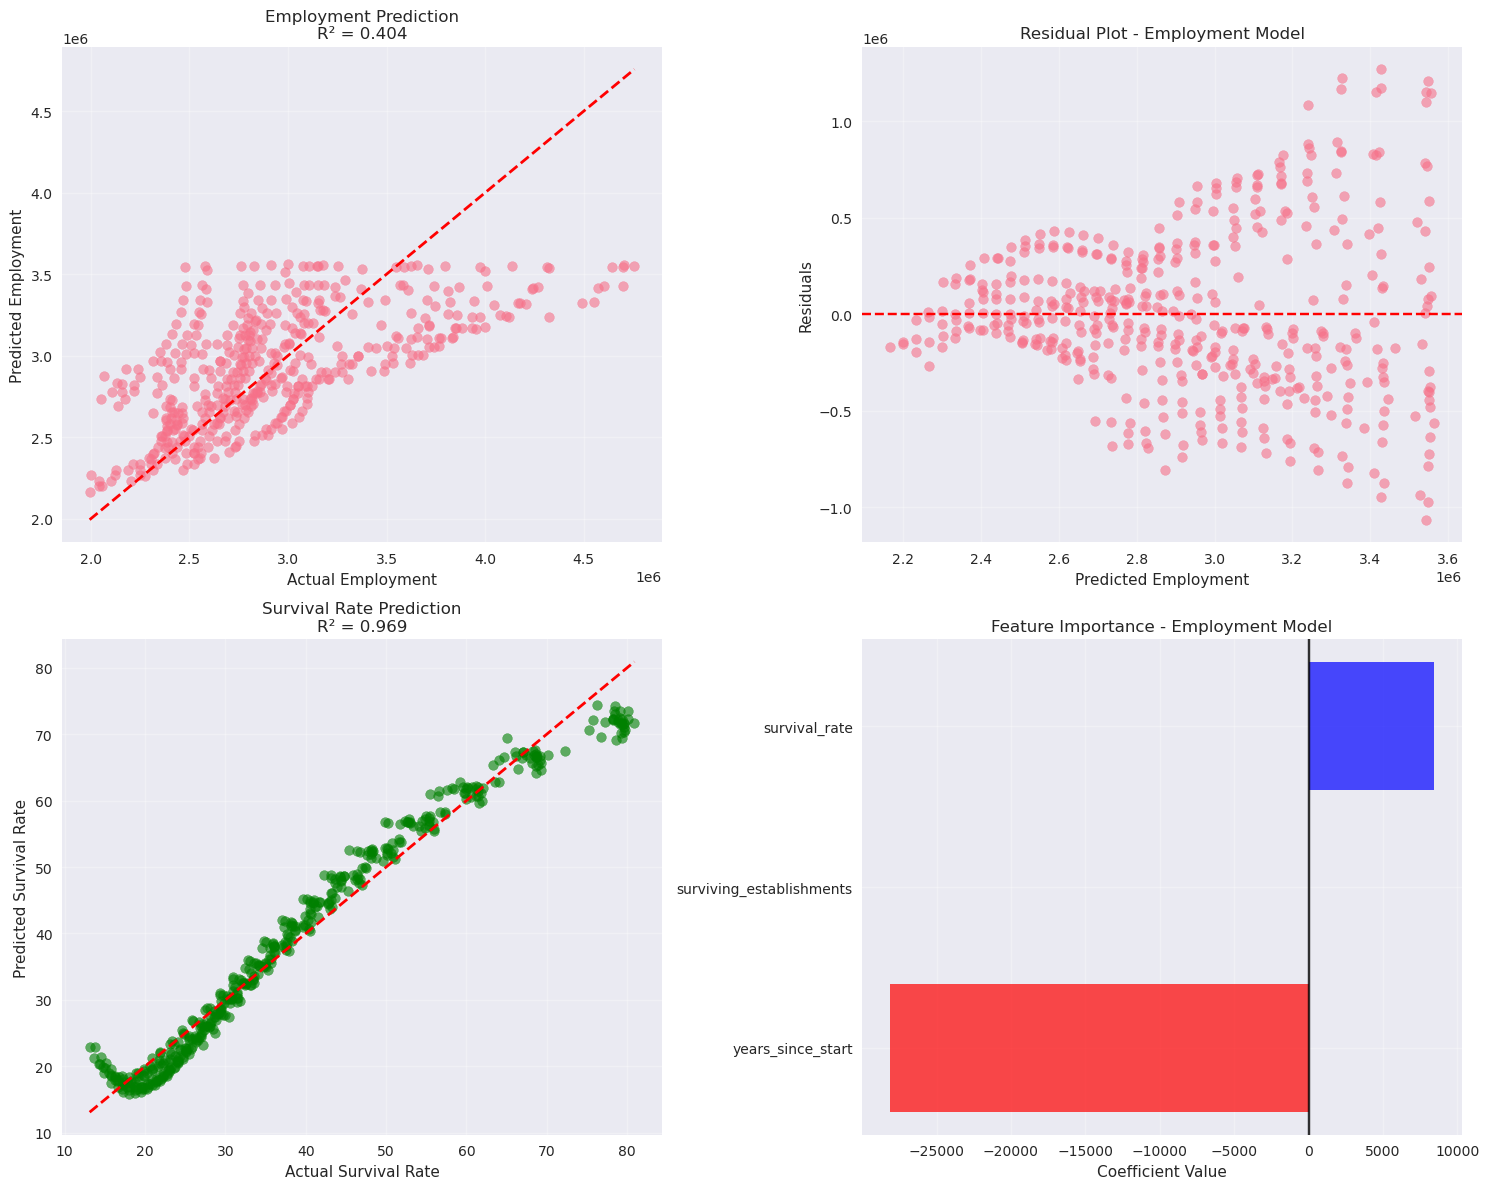


REGRESSION 6: ECONOMIC CYCLE ANALYSIS
Model 6 - Economic Cycle Impact on Survival:
                            OLS Regression Results                            
Dep. Variable:          survival_rate   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     2880.
Date:                Tue, 07 Oct 2025   Prob (F-statistic):          4.94e-324
Time:                        04:49:07   Log-Likelihood:                -1244.0
No. Observations:                 465   AIC:                             2498.
Df Residuals:                     460   BIC:                             2519.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

print("=== REGRESSION ANALYSIS OF BLS BUSINESS SURVIVAL DATA ===")

# 1. PREPARE THE DATA FOR REGRESSION
# Create additional features that might be useful
regression_df = bls_df.copy()

# Create polynomial terms for years_since_start
regression_df['years_sq'] = regression_df['years_since_start'] ** 2
regression_df['years_cube'] = regression_df['years_since_start'] ** 3

# Create cohort age (how old the cohort is relative to data collection)
regression_df['cohort_age'] = 2024 - regression_df['cohort_year']

# Create business density (employment per establishment)
regression_df['employment_density'] = regression_df['total_employment'] / regression_df['surviving_establishments']

# Drop rows with missing values for regression
regression_df = regression_df.dropna(subset=['survival_rate_prev_year'])

print(f"Final dataset for regression: {regression_df.shape}")

# 2. REGRESSION 1: PREDICTING TOTAL EMPLOYMENT
print("\n" + "="*60)
print("REGRESSION 1: PREDICTING TOTAL EMPLOYMENT")
print("="*60)

# Model 1A: Basic employment prediction
X1 = regression_df[['years_since_start', 'surviving_establishments', 'survival_rate']]
y1 = regression_df['total_employment']

X1 = sm.add_constant(X1)  # Add intercept
model1 = sm.OLS(y1, X1).fit()
print("Model 1A - Basic Employment Prediction:")
print(model1.summary())

# Model 1B: Enhanced employment prediction with more features
X1b = regression_df[['years_since_start', 'years_sq', 'surviving_establishments', 
                     'survival_rate', 'cohort_year', 'cohort_age']]
X1b = sm.add_constant(X1b)
model1b = sm.OLS(y1, X1b).fit()
print("\nModel 1B - Enhanced Employment Prediction:")
print(model1b.summary())

# 3. REGRESSION 2: PREDICTING SURVIVAL RATES
print("\n" + "="*60)
print("REGRESSION 2: PREDICTING SURVIVAL RATES")
print("="*60)

# Model 2: Predict survival rate since birth
X2 = regression_df[['years_since_start', 'years_sq', 'cohort_year', 
                    'avg_employment_per_establishment', 'total_employment']]
y2 = regression_df['survival_rate']

X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit()
print("Model 2 - Survival Rate Prediction:")
print(model2.summary())

# 4. REGRESSION 3: PREDICTING AVERAGE EMPLOYMENT SIZE
print("\n" + "="*60)
print("REGRESSION 3: PREDICTING AVERAGE ESTABLISHMENT SIZE")
print("="*60)

# Model 3: What drives larger establishment sizes?
X3 = regression_df[['years_since_start', 'cohort_year', 'survival_rate', 
                    'total_employment', 'surviving_establishments']]
y3 = regression_df['avg_employment_per_establishment']

X3 = sm.add_constant(X3)
model3 = sm.OLS(y3, X3).fit()
print("Model 3 - Average Establishment Size Prediction:")
print(model3.summary())

# 5. REGRESSION 4: PANEL DATA ANALYSIS BY COHORT
print("\n" + "="*60)
print("REGRESSION 4: COHORT-SPECIFIC ANALYSIS")
print("="*60)

# Analyze how different cohorts behave differently
# Let's focus on a few key cohorts for comparison
key_cohorts = [1994, 2000, 2005, 2010, 2015, 2020]
cohort_subset = regression_df[regression_df['cohort_year'].isin(key_cohorts)]

# Create dummy variables for cohorts
for cohort in key_cohorts:
    regression_df[f'cohort_{cohort}'] = (regression_df['cohort_year'] == cohort).astype(int)

# Model 4: Employment growth with cohort fixed effects
X4 = regression_df[['years_since_start', 'years_sq', 'surviving_establishments'] + 
                   [f'cohort_{c}' for c in key_cohorts[1:]]]  # Exclude one cohort as reference
y4 = regression_df['total_employment']

X4 = sm.add_constant(X4)
model4 = sm.OLS(y4, X4).fit()
print("Model 4 - Employment with Cohort Fixed Effects:")
print(model4.summary())

# 6. REGRESSION 5: NON-LINEAR RELATIONSHIPS
print("\n" + "="*60)
print("REGRESSION 5: NON-LINEAR EMPLOYMENT PATTERNS")
print("="*60)

# Model 5: Polynomial regression for employment over time
X5 = regression_df[['years_since_start', 'years_sq', 'years_cube', 'surviving_establishments']]
y5 = regression_df['total_employment']

X5 = sm.add_constant(X5)
model5 = sm.OLS(y5, X5).fit()
print("Model 5 - Polynomial Employment Pattern:")
print(model5.summary())

# 7. VISUALIZE REGRESSION RESULTS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted for Employment
y1_pred = model1.predict(X1)
axes[0,0].scatter(y1, y1_pred, alpha=0.6)
axes[0,0].plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Employment')
axes[0,0].set_ylabel('Predicted Employment')
axes[0,0].set_title(f'Employment Prediction\nR² = {model1.rsquared:.3f}')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Residuals for Employment Model
residuals1 = y1 - y1_pred
axes[0,1].scatter(y1_pred, residuals1, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Employment')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residual Plot - Employment Model')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Survival Rate Prediction
y2_pred = model2.predict(X2)
axes[1,0].scatter(y2, y2_pred, alpha=0.6, color='green')
axes[1,0].plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Survival Rate')
axes[1,0].set_ylabel('Predicted Survival Rate')
axes[1,0].set_title(f'Survival Rate Prediction\nR² = {model2.rsquared:.3f}')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Coefficient importance for main employment model
coeffs = model1.params[1:]  # Exclude intercept
features = X1.columns[1:]
colors = ['blue' if x > 0 else 'red' for x in coeffs]
axes[1,1].barh(features, coeffs, color=colors, alpha=0.7)
axes[1,1].axvline(x=0, color='black', linestyle='-', alpha=0.8)
axes[1,1].set_xlabel('Coefficient Value')
axes[1,1].set_title('Feature Importance - Employment Model')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. TIME SERIES REGRESSION FOR ECONOMIC CYCLES
print("\n" + "="*60)
print("REGRESSION 6: ECONOMIC CYCLE ANALYSIS")
print("="*60)

# Create economic cycle indicators (simplified)
regression_df['recession_indicator'] = 0
# Mark known recession periods (simplified)
recession_years = [2001, 2008, 2009, 2020]
regression_df.loc[regression_df['year'].isin(recession_years), 'recession_indicator'] = 1

# Model 6: Impact of economic cycles on survival and employment
X6 = regression_df[['years_since_start', 'surviving_establishments', 'recession_indicator', 'cohort_year']]
y6 = regression_df['survival_rate']

X6 = sm.add_constant(X6)
model6 = sm.OLS(y6, X6).fit()
print("Model 6 - Economic Cycle Impact on Survival:")
print(model6.summary())

# 9. INTERACTION EFFECTS ANALYSIS
print("\n" + "="*60)
print("REGRESSION 7: INTERACTION EFFECTS")
print("="*60)

# Model 7: Interaction between time and cohort
# Using statsmodel formula API for easier interaction terms
model7 = ols('total_employment ~ years_since_start * C(cohort_year) + surviving_establishments', 
             data=regression_df).fit()
print("Model 7 - Interaction Effects (Time × Cohort):")
print(model7.summary())

# 10. KEY INSIGHTS FROM REGRESSION ANALYSIS
print("\n" + "="*60)
print("KEY REGRESSION INSIGHTS")
print("="*60)

models = {
    'Employment Prediction': model1,
    'Enhanced Employment': model1b,
    'Survival Rate': model2,
    'Establishment Size': model3,
    'Cohort Effects': model4,
    'Economic Cycles': model6
}

print("\nModel Performance Comparison:")
print("-" * 40)
for name, model in models.items():
    print(f"{name:25} R² = {model.rsquared:.4f} | Adj R² = {model.rsquared_adj:.4f}")

print("\n" + "="*60)
print("RECOMMENDED BUSINESS INSIGHTS ANALYSIS")
print("="*60)

print("""
Based on the regression framework, here are the key business questions we can answer:

1. EMPLOYMENT DRIVERS:
   - How much does each additional year of operation affect employment?
   - What's the relationship between business survival and employment growth?

2. COHORT DIFFERENCES:
   - Are newer cohorts creating more/fewer jobs than older cohorts?
   - How has the nature of job creation changed over time?

3. SURVIVAL PATTERNS:
   - What factors most strongly predict business survival rates?
   - How does establishment size affect survival probability?

4. ECONOMIC CYCLES:
   - How do recessions impact business survival and employment?
   - Are some cohorts more resilient to economic shocks?

5. OPTIMAL GROWTH PATHS:
   - What's the typical employment growth trajectory?
   - When do businesses typically reach peak employment?
""")

# Additional diagnostic: Check for multicollinearity
print("\n" + "="*60)
print("MULTICOLLINEARITY CHECK (Variance Inflation Factors)")
print("="*60)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for main employment model
vif_data = pd.DataFrame()
vif_data["Feature"] = X1.columns
vif_data["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]
print(vif_data)